# An illustration of the MARBLE method on the FitzHugh-Nagumo model

In [1]:
#!/usr/bin/env python3
# FHN_MARBLE_demo.py - Simplified FitzHugh-Nagumo model analyzed with MARBLE
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch

import MARBLE
from MARBLE import plotting, geometry
import MARBLE.preprocessing as mprep
import MARBLE.dynamics as dynamics

def get_pos_vel(n_trajectories,params, t, area, alpha=0.05):
    X0_range = dynamics.initial_conditions(n_trajectories, len(params), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, params):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))

    pos, vel = dynamics.embed_parabola(pos, vel, alpha=alpha)
    return pos, vel

Simplified FitzHugh-Nagumo MARBLE Demo
Generating 200 trajectories...


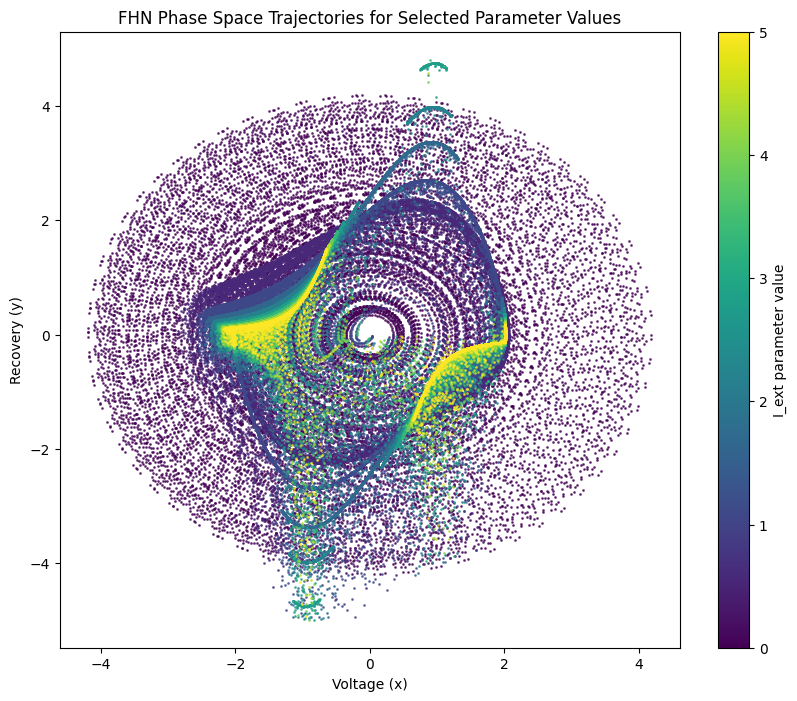

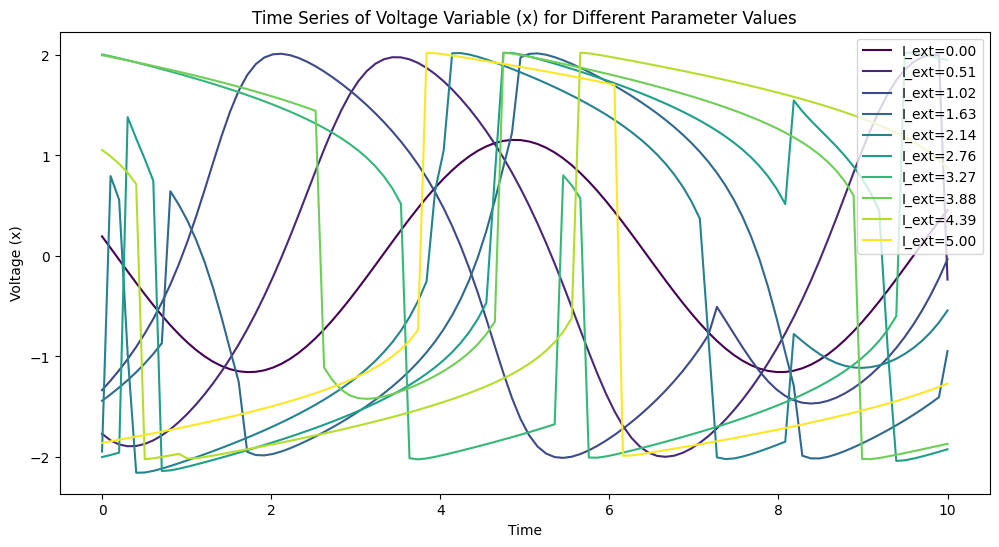

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Default FHN model parameters
FHN_PARAMS = {
    "a": 0.7,
    "b": 0.8,
    "tau": 12.5,
    "I_ext": 0.5
}

# MARBLE parameters
MARBLE_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'lr': 0.01,
    'momentum': 0.9,
    'diffusion': True,
    'hidden_channels': [64, 32],
    'out_channels': 5,
    'batch_norm': True,
    'seed': 42
}

print("Simplified FitzHugh-Nagumo MARBLE Demo")
print("=" * 40)

# Setup
n_trajectories = 200  # Number of trajectories to simulate
ntime = 100
t_span = np.linspace(0, 10, ntime)  # Time points
area = [[-2.0, -4.], [2.0, .0]]

# Parameter to vary (set to None for fixed parameters)
vary_param = 'tau'
param_range = [1., 100.]
n_params = 50
params = np.linspace(param_range[0], param_range[1], n_params)

print(f"Generating {n_trajectories} trajectories...")

os.makedirs(f'temp_Figures/fhn_{vary_param}', exist_ok=True)
os.makedirs(f'temp_Data/fhn_{vary_param}', exist_ok=True)

pos_list,vel_list = get_pos_vel(n_trajectories,params, t_span, area,alpha=0.05)

# Plot phase space trajectories for 5 sampled parameters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = None

# Sample 5 evenly spaced parameter indices
sample_indices = np.linspace(0, n_params-1, 10, dtype=int)
param_values = params[sample_indices]
colors = plt.cm.viridis(np.linspace(0, 1, 10))

scatter_plots = []
for idx, param_idx in enumerate(sample_indices):
    scatter = ax.scatter(pos_list[param_idx][:, 0], pos_list[param_idx][:, 1],
                        c=[colors[idx]], alpha=0.7, s=1)
    scatter_plots.append(scatter)

# Create colorbar with actual parameter values
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=param_range[0], vmax=param_range[1]))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(f'{vary_param} parameter value')

ax.set_title('FHN Phase Space Trajectories for Selected Parameter Values')
ax.set_xlabel('Voltage (x)')
ax.set_ylabel('Recovery (y)')
plt.savefig(f'temp_Figures/fhn_{vary_param}/phase_space_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot time series for variable x
plt.figure(figsize=(12, 6))
for idx, param_idx in enumerate(sample_indices[:]):
    x_timeseries = pos_list[param_idx][:, 0]  # Extract x variable
    plt.plot(t_span, x_timeseries[param_idx*ntime:(param_idx+1)*ntime], color=colors[idx], 
             label=f'{vary_param}={params[param_idx]:.2f}')

plt.title('Time Series of Voltage Variable (x) for Different Parameter Values')
plt.xlabel('Time')
plt.ylabel('Voltage (x)')
plt.legend()
plt.savefig(f'temp_Figures/fhn_{vary_param}/voltage_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

/home/honglab/leijiaxin/MARBLE/fhn_phase_plane_utils.py:98: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(fixed_point_eqs, guess)


Tracking limit cycles for 60 parameter values...


Found 13 limit cycle points
Processing 13 limit cycle data points for plotting


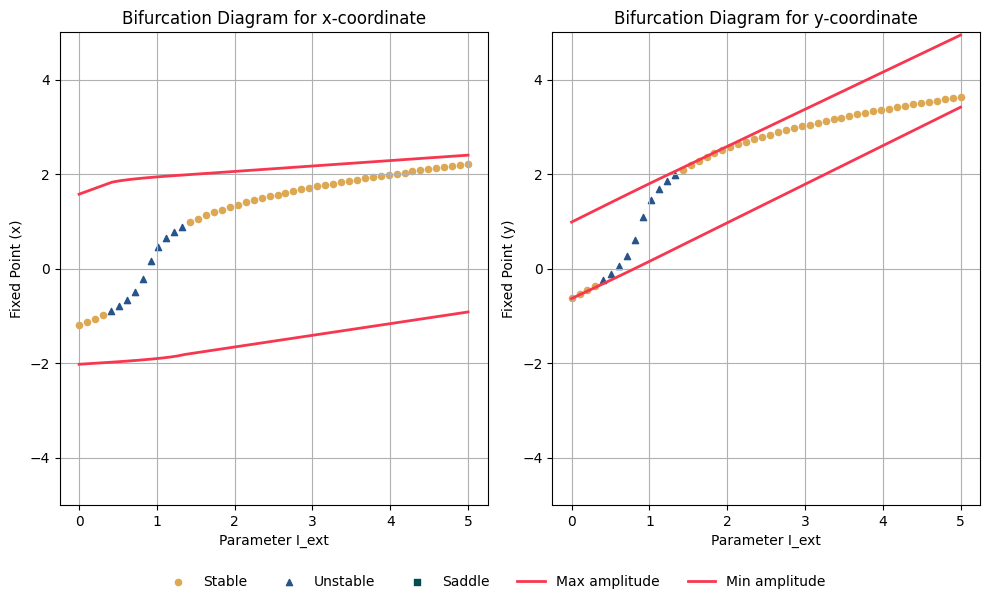

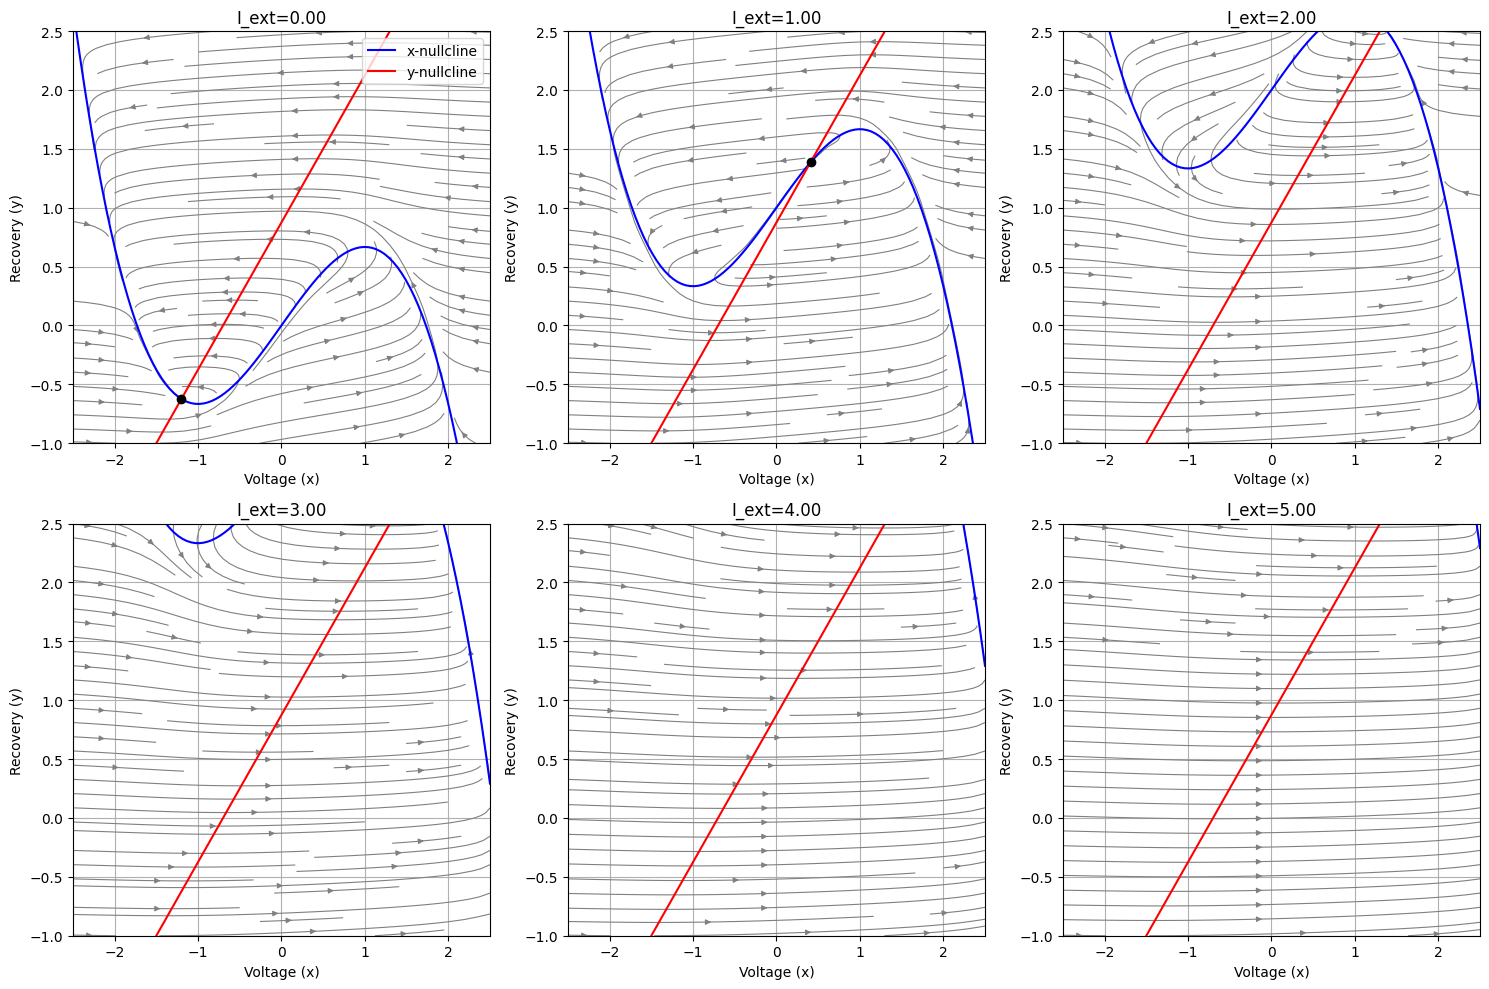

In [3]:
# Create bifurcation plot using the utility function
from fhn_phase_plane_utils import *

# Setup other parameters (all parameters except the one we're varying)
other_params = FHN_PARAMS.copy()
del other_params[vary_param]  # Remove the parameter we're varying

# Call the bifurcation diagram function
fig, axes = plot_bifurcation_diagram(
    param_name=vary_param,
    param_range=param_range,
    other_params=other_params,
    num_points=n_params,
    figsize=(10, 6),
    y_lim=[-5, 5],
)

# Save the bifurcation diagram
plt.savefig(f'temp_Figures/fhn_{vary_param}/bifurcation_diagram_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

# Create phase plane plots for different parameter values
param_values = np.linspace(param_range[0], param_range[1], 6)  # Sample 6 values
fig = parameter_sweep_phase_planes(
    param_name=vary_param,
    param_values=param_values,
    other_params=other_params,
    x_range=[-2.5, 2.5],
    y_range=[-1.0, 2.5],
    figsize=(15, 10)
)

# Save the phase plane plots
plt.savefig(f'temp_Figures/fhn_{vary_param}/phase_planes_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

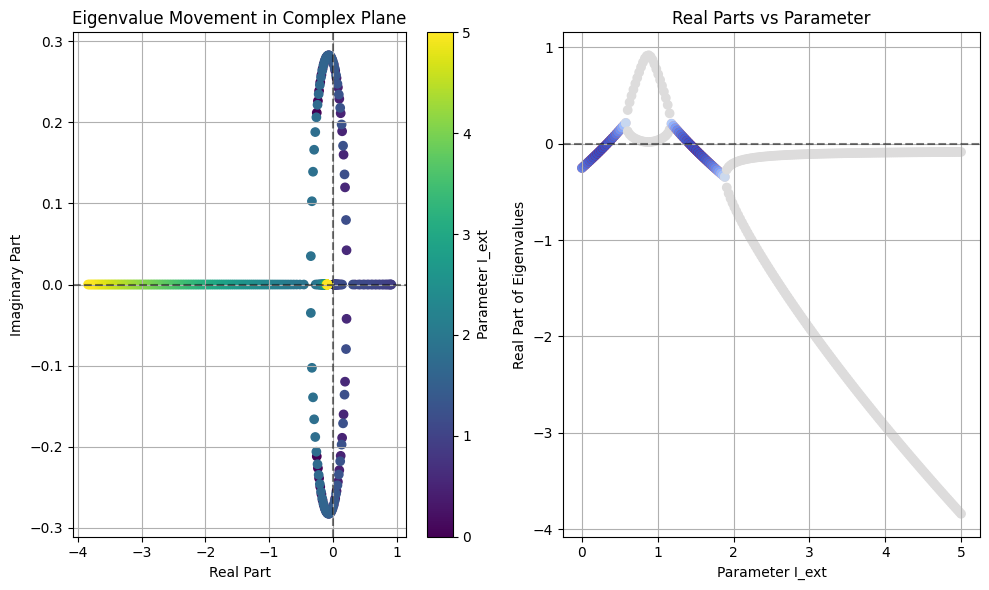

In [4]:
# Example usage - track eigenvalues for a point near b=1.2
point_near_transition = [1.0, 0.0]  # Starting point to track (x,y)
fig, axes = plot_eigenvalue_movement(vary_param,param_range, point_near_transition, FHN_PARAMS)
# Save the eigenvalue movement plot
plt.savefig(f'temp_Figures/fhn_{vary_param}/eigenvalue_movement_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
load_dataset = False 
load_model = False
save_path = f'temp_Data/fhn_{vary_param}/fhn_dataset_{vary_param}.pkl'
model_path = f'temp_Data/fhn_{vary_param}/fhn_model_{vary_param}.pkl'

k = 100
# Prepare dataset and train model
if not load_dataset:
    data = MARBLE.construct_dataset(anchor=pos_list, vector=vel_list, spacing=0.03,k=k)
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Dataset saved to {save_path}")
else:
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Dataset loaded from {save_path}")

model = MARBLE.net(data, params=MARBLE_PARAMS)

if not load_model:
    model.fit(data, outdir='temp_Data')
    # Save the trained model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")
else:
    # Load the trained model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {model_path}")

# Transform data and calculate distances
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)


---- Embedding dimension: 3
---- Signal dimension: 3
---- Computing kernels ... 
---- Computing full spectrum ...
              (if this takes too long, then run construct_dataset()
              with number_of_eigenvectors specified) Dataset saved to temp_Data/fhn_I_ext/fhn_dataset_I_ext.pkl

---- Settings: 

batch_size : 64
epochs : 50
lr : 0.01
momentum : 0.9
diffusion : True
hidden_channels : [64, 32]
out_channels : 5
batch_norm : batch_norm
seed : 42
dropout : 0.0
bias : True
order : 2
inner_product_features : False
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
emb_norm : False
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  39
---- Total number of parameters:  4998

Using device cuda:0

---- Training network ...

---- Timestamp: 20250412-191816

Epoch: 0, Training loss: 1.109732, Validation loss: 1.0266, lr: 0.0100 *
Epoch: 1, Training loss: 1.032449, Validation loss: 1.0534, lr: 0.0100
Epoch: 2, Tr

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.


<Figure size 400x400 with 0 Axes>

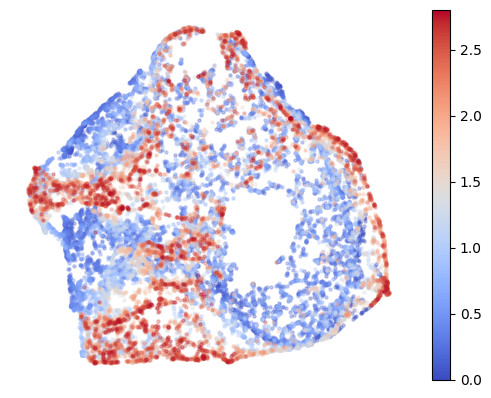

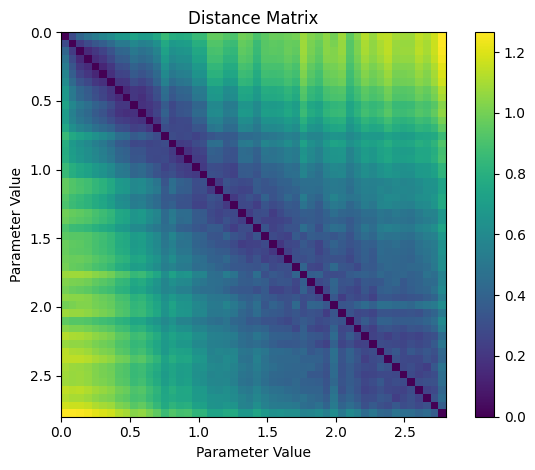

Performed PCA embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
Y

<Figure size 400x400 with 0 Axes>

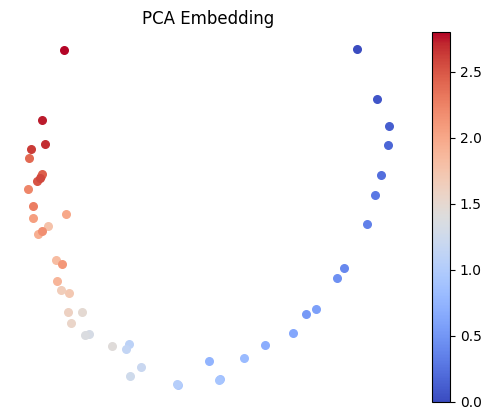

Performed tsne embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

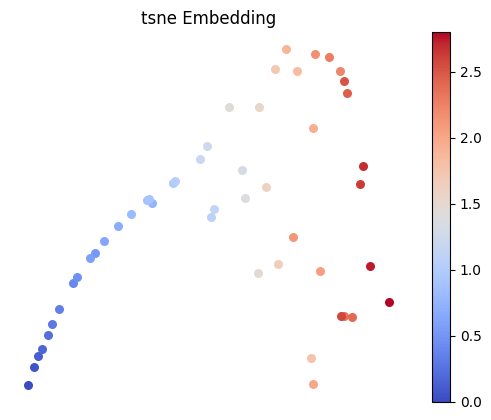

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performed umap embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

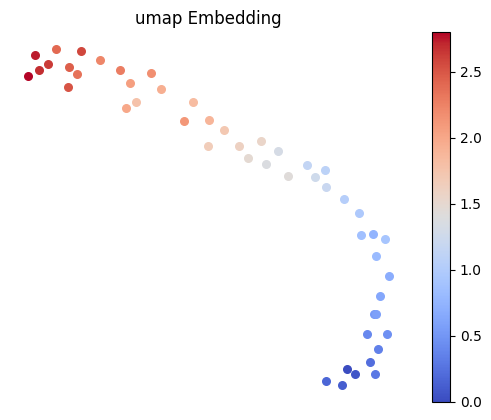

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:328: UserWarning: The number of connected components of the neighbors graph is 21 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of 

Performed Isomap embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories

<Figure size 400x400 with 0 Axes>

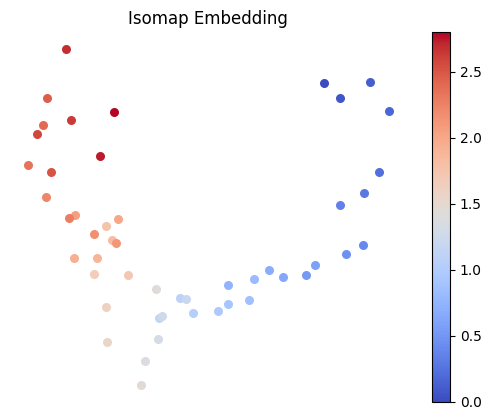

Performed MDS embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
Y

<Figure size 400x400 with 0 Axes>

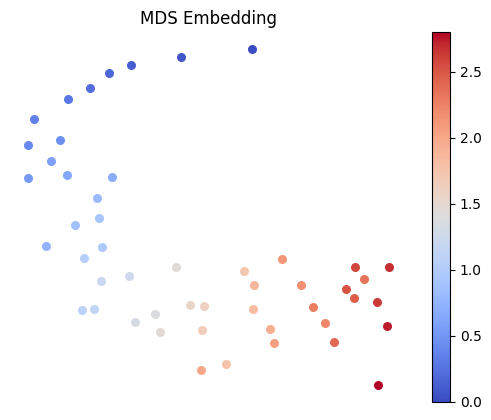

Demo completed. Results saved to temp_Figures/ directory.


In [14]:
# Visualize embeddings
plt.figure(figsize=(4, 4))
ax = plotting.embedding(data, params[data.y.numpy().astype(int)])

plt.savefig(f'temp_Figures/fhn_{vary_param}/embedding_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()
# Plot distance matrix
plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(data.dist, extent=[params[0], params[-1], params[-1], params[0]])
plt.colorbar(im)
plt.title('Distance Matrix')
plt.xlabel('Parameter Value')
plt.ylabel('Parameter Value')
plt.tight_layout()
plt.savefig(f'temp_Figures/fhn_distances_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot different embeddings
embed_types = ['PCA', 'tsne', 'umap', 'Isomap', 'MDS']

for embed_typ in embed_types:
    emb, _ = geometry.embed(data.dist, embed_typ=embed_typ)
    plt.figure(figsize=(4, 4))
    ax = plotting.embedding(emb, params, s=30, alpha=1)
    plt.title(f'{embed_typ} Embedding')
    plt.savefig(f'temp_Figures/fhn_{vary_param}/{embed_typ.lower()}_{vary_param}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("=" * 40)
print("Demo completed. Results saved to temp_Figures/ directory.")